# Imports

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [38]:
import pandas as pd
import seaborn as sns
import sklearn
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

from config import val_split_seed

# Data Preperation

In [3]:
a = pd.read_csv("./BankA.csv")
b = pd.read_csv("./BankB.csv")
c = pd.read_csv("./BankC.csv")

In [6]:
a_samp = a.sample(n=100)
b_samp = b.sample(n=100)
c_samp = c.sample(n=100)

# a_b_samp = a_samp.append(b_samp, ignore_index=True)
# all_samp = a_b_samp.append(c_samp, ignore_index=True)

all_samp = pd.concat([a_samp, b_samp, c_samp], ignore_index=True)

In [7]:
#sns.pairplot(all_samp, height=3);

In [11]:
#profile = ProfileReport(all_samp, title="Profiling Report")
#profile.to_notebook_iframe()

In [12]:
all_samp.head(3)

,institute,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,Bank A,32,Private,454198,11th,7,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
1,Bank A,49,State-gov,141116,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,Bank A,38,Private,213489,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,40,United-States,>50K


In [26]:
# Native Country (Rassistisch?)
# Gender (sexismus)
# Race (Rassistisch!)
# Relationship (Husband, Wife einfach zu Married?)
# Educational-num oder education weg, je nach dem ob one hot encoding oder nicht

In [23]:
df_all = pd.concat([a, b, c], ignore_index=True)
df_a = a
df_b = b
df_c = c

In [24]:
drop_this = ["institute","education","race","gender","native-country"]
df_all = df_all.drop(drop_this, axis = 1)
df_a = df_a.drop(drop_this, axis = 1)
df_b = df_b.drop(drop_this, axis = 1)
df_c = df_c.drop(drop_this, axis = 1)


In [25]:
df_all.loc[df_all["relationship"].isin(["Husband", "Wife"]), "relationship"] = "Married"
df_a.loc[df_a["relationship"].isin(["Husband", "Wife"]), "relationship"] = "Married"
df_b.loc[df_b["relationship"].isin(["Husband", "Wife"]), "relationship"] = "Married"
df_c.loc[df_c["relationship"].isin(["Husband", "Wife"]), "relationship"] = "Married"

In [26]:
df_all = pd.get_dummies(df_all, columns=["workclass", "marital-status", "occupation", "relationship"])
df_a = pd.get_dummies(df_a, columns=["workclass", "marital-status", "occupation", "relationship"])
df_b = pd.get_dummies(df_b, columns=["workclass", "marital-status", "occupation", "relationship"])
df_c = pd.get_dummies(df_c, columns=["workclass", "marital-status", "occupation", "relationship"])

In [27]:
df_all['income'] = df_all['income'].map({'>50K': 1, '<=50K': 0})
df_a['income'] = df_a['income'].map({'>50K': 1, '<=50K': 0})
df_b['income'] = df_b['income'].map({'>50K': 1, '<=50K': 0})
df_c['income'] = df_c['income'].map({'>50K': 1, '<=50K': 0})

In [29]:
y_all = df_all['income']
X_all = df_all.drop('income', axis=1)

y_a = df_a['income']
X_a = df_a.drop('income', axis=1)

y_b = df_b['income']
X_b = df_b.drop('income', axis=1)

y_c = df_c['income']
X_c = df_c.drop('income', axis=1)

In [30]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=0)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=0.2, random_state=0)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=0)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=0)

# Neural Network Model

In [43]:
input_shape = [X_train_all.shape[1]]

In [50]:
X_train_all = X_train_all.astype('float32')
X_test_all = X_test_all.astype('float32')
y_train_all = y_train_all.astype('float32')
y_test_all = y_test_all.astype('float32')

In [45]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'), 
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

In [46]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [47]:
#If there hasn't been at least an improvement of 0.001 in the validation loss 
#over the previous 20 epochs, then stop the training and keep the best model you found.
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

In [51]:
# Train ALL
history = model.fit(
    X_train_all, y_train_all,
    validation_data=(X_test_all, y_test_all),
    batch_size=32,
    epochs=7,
    callbacks=[early_stopping],
)

Epoch 1/10


20000/20000 [==============================] - 77s 4ms/step - loss: 0.3530 - binary_accuracy: 0.8373 - val_loss: 0.3386 - val_binary_accuracy: 0.8429
Epoch 2/10
20000/20000 [==============================] - 78s 4ms/step - loss: 0.3436 - binary_accuracy: 0.8420 - val_loss: 0.3402 - val_binary_accuracy: 0.8410
Epoch 3/10
20000/20000 [==============================] - 78s 4ms/step - loss: 0.3410 - binary_accuracy: 0.8427 - val_loss: 0.3394 - val_binary_accuracy: 0.8415
Epoch 4/10
20000/20000 [==============================] - 79s 4ms/step - loss: 0.3399 - binary_accuracy: 0.8437 - val_loss: 0.3367 - val_binary_accuracy: 0.8426
Epoch 5/10
20000/20000 [==============================] - 77s 4ms/step - loss: 0.3395 - binary_accuracy: 0.8436 - val_loss: 0.3388 - val_binary_accuracy: 0.8427
Epoch 6/10
20000/20000 [==============================] - 79s 4ms/step - loss: 0.3390 - binary_accuracy: 0.8443 - val_loss: 0.3389 - val_binary_accuracy: 0.8417
Epoch 7/10
20000/20000 [========

<Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>

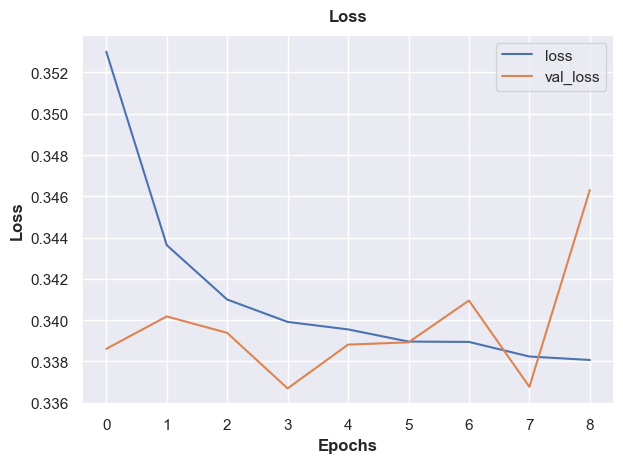

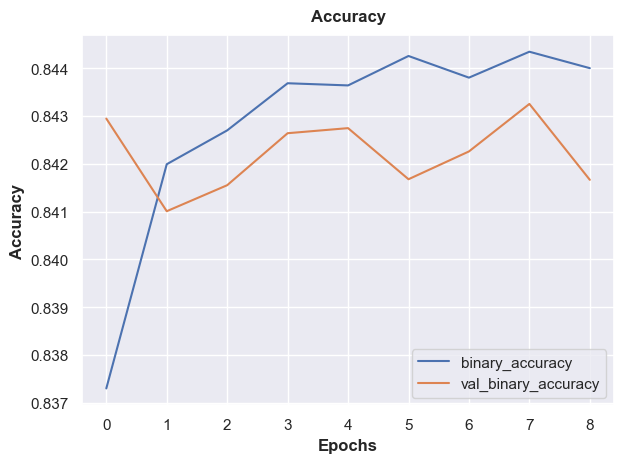

In [75]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss", xlabel='Epochs', ylabel='Loss')
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy", xlabel='Epochs', ylabel='Accuracy')